In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy as gp
from matplotlib import rcParams

In [8]:
abnb_df = pd.read_csv('../data/clean/abnb_clean.gz', low_memory=False)
#pd.read_csv(item, skipinitialspace=True, usecols=copy_cols1, sep=',', low_memory = False)
abnb_df = abnb_df.drop(columns = 'Unnamed: 0')
#abnb_df['last_scraped'] = pd.to_datetime(abnb_df['last_scraped'], infer_datetime_format = True )
abnb_df['year'] = pd.to_datetime(abnb_df['last_scraped']).dt.to_period('Y')
abnb_df['availability_pct'] = abnb_df['availability_365']/365 *100
abnb_df["borough"] = abnb_df["borough"].astype("str")
abnb_df["borough"] = abnb_df["borough"].str.upper()


In [9]:
acs_df = pd.read_csv('../data/clean/acs_estimate.csv', low_memory=False)

In [10]:
zrent_df = pd.read_csv('../data/clean/zrentals.csv', low_memory=False)

In [11]:
zrent_df

,zip_code,state,city,borough,date,mean_rent
0,11385,NY,New York,QUEENS,2015-03-31,2216.568524
1,10467,NY,New York,BRONX,2015-03-31,1303.888993
2,11226,NY,New York,BROOKLYN,2015-03-31,1909.383681
3,11220,NY,New York,BROOKLYN,2015-03-31,1686.421706
4,11207,NY,New York,BROOKLYN,2015-03-31,2113.610448
...,...,...,...,...,...,...
8731,10282,NY,New York,MANHATTAN,2022-10-31,7836.527778
8732,10069,NY,New York,MANHATTAN,2022-10-31,5778.583333
8733,10004,NY,New York,MANHATTAN,2022-10-31,4823.220238
8734,10006,NY,New York,MANHATTAN,2022-10-31,4180.540793


In [7]:
year_count = list(abnb_df.groupby(['year'])['id'].size())
years = ['2015','2016','2017','2018','2019','2020','2021','2022']

In [230]:
abnb_df.keys()

Index(['id', 'last_scraped', 'host_id', 'host_name', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'bedrooms', 'availability_365',
       'calculated_host_listings_count', 'geom', 'zipcode', 'borough', 'year',
       'availability_pct'],
      dtype='object')

In [8]:
def listing_clean(data):
    year_count = list(data.groupby(['year'])['id'].size())
    x=len(years)
    print('Number of NYC Airbnb Listings per Year:')
    for i in range(0,x):
        print('\t'+years[i] +':',year_count[i])
#    print('Number of features in dataset:', data.shape[1])
#    print('Avarage price is : $',round(data.price.mean()))
#    print('Number of hosts/suppliers: ', data.host_id.nunique())
#    print('Number of suburbs: ', data.neighbourhood.nunique())
    return

In [9]:
listing_clean(abnb_df)

Number of NYC Airbnb Listings per Year:
	2015: 33446
	2016: 39133
	2017: 46742
	2018: 48191
	2019: 49773
	2020: 36275
	2021: 36116
	2022: 45827


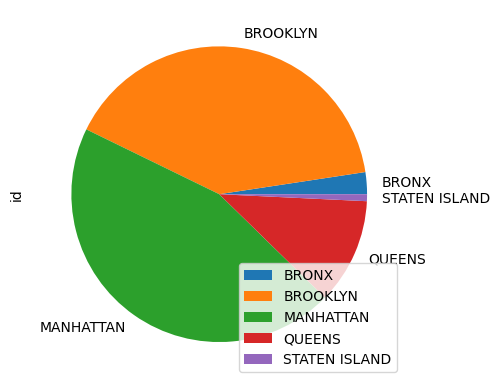

In [10]:
abnb_df.groupby(['borough']).count().plot(kind='pie', y='id')
plt.legend(loc = 'lower right')
plt.show()

<AxesSubplot:>

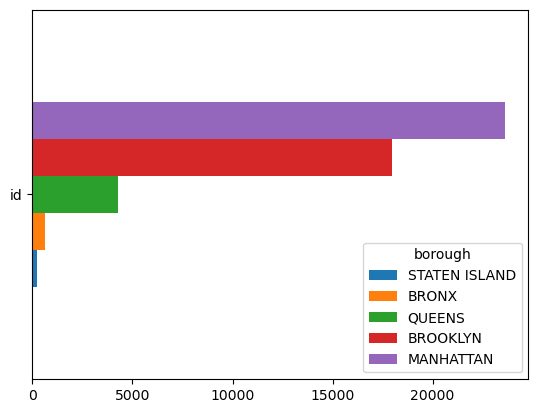

In [15]:
#color display?
abnb_df[abnb_df['year'] == '2017'].groupby(['borough'])['id'].count().to_frame().sort_values('id').T.plot.barh()

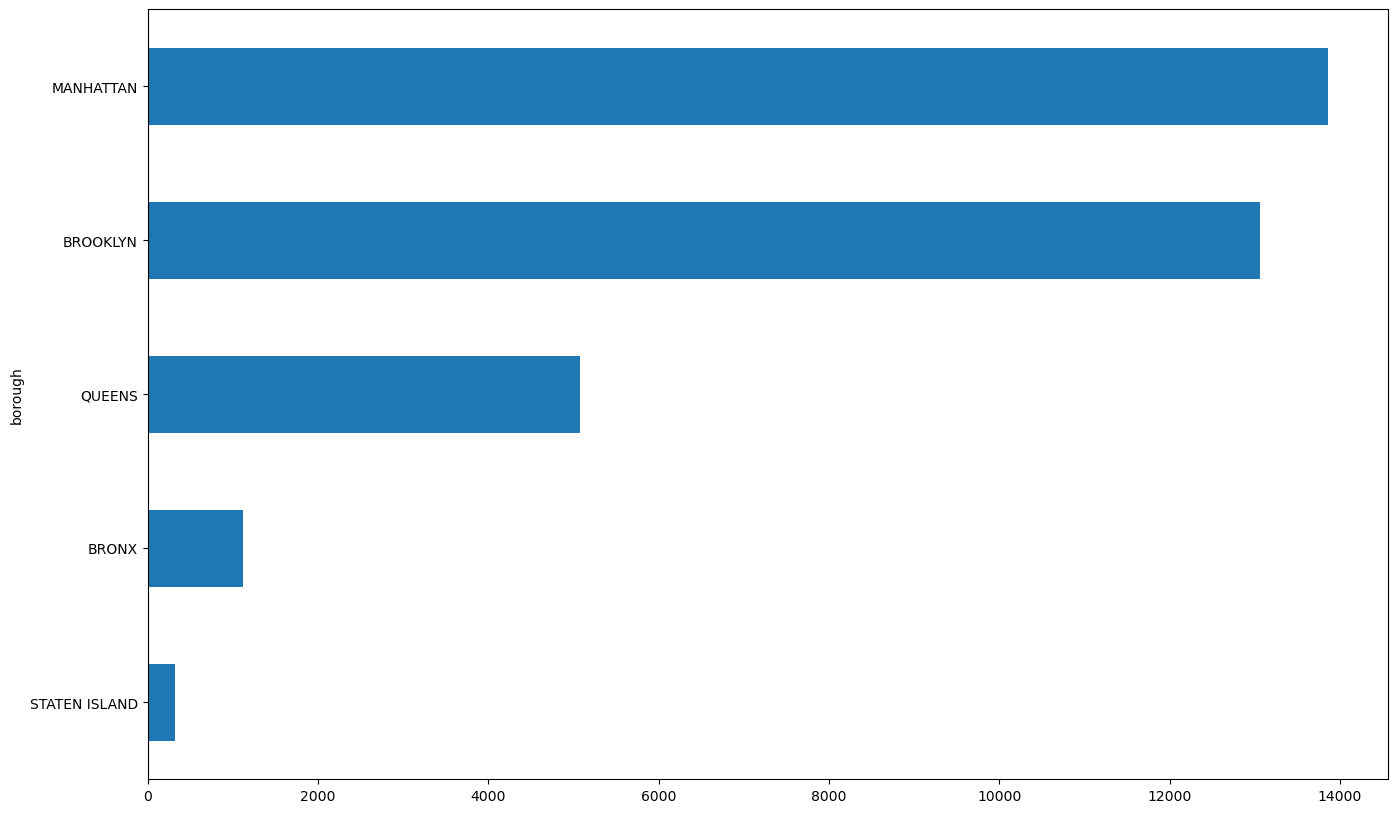

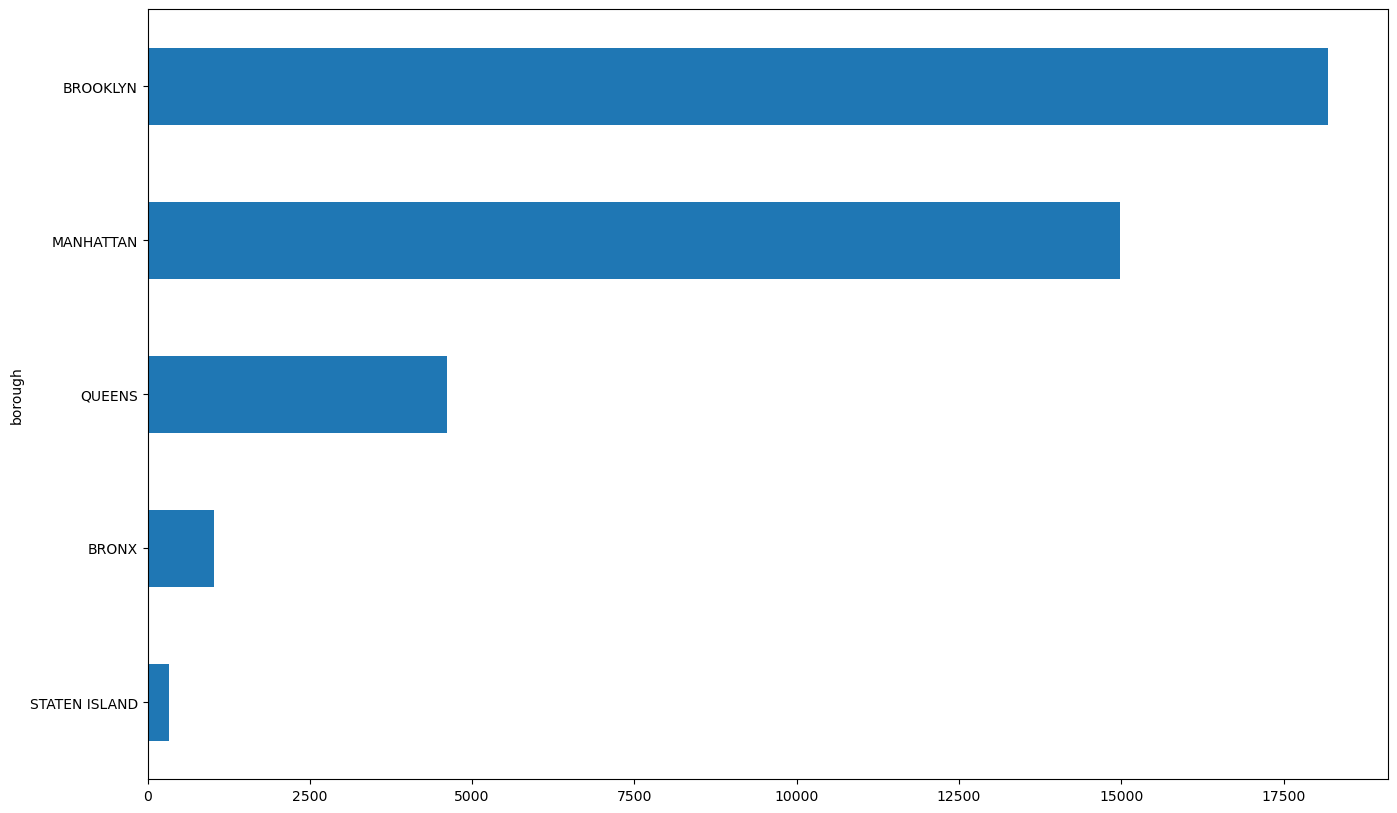

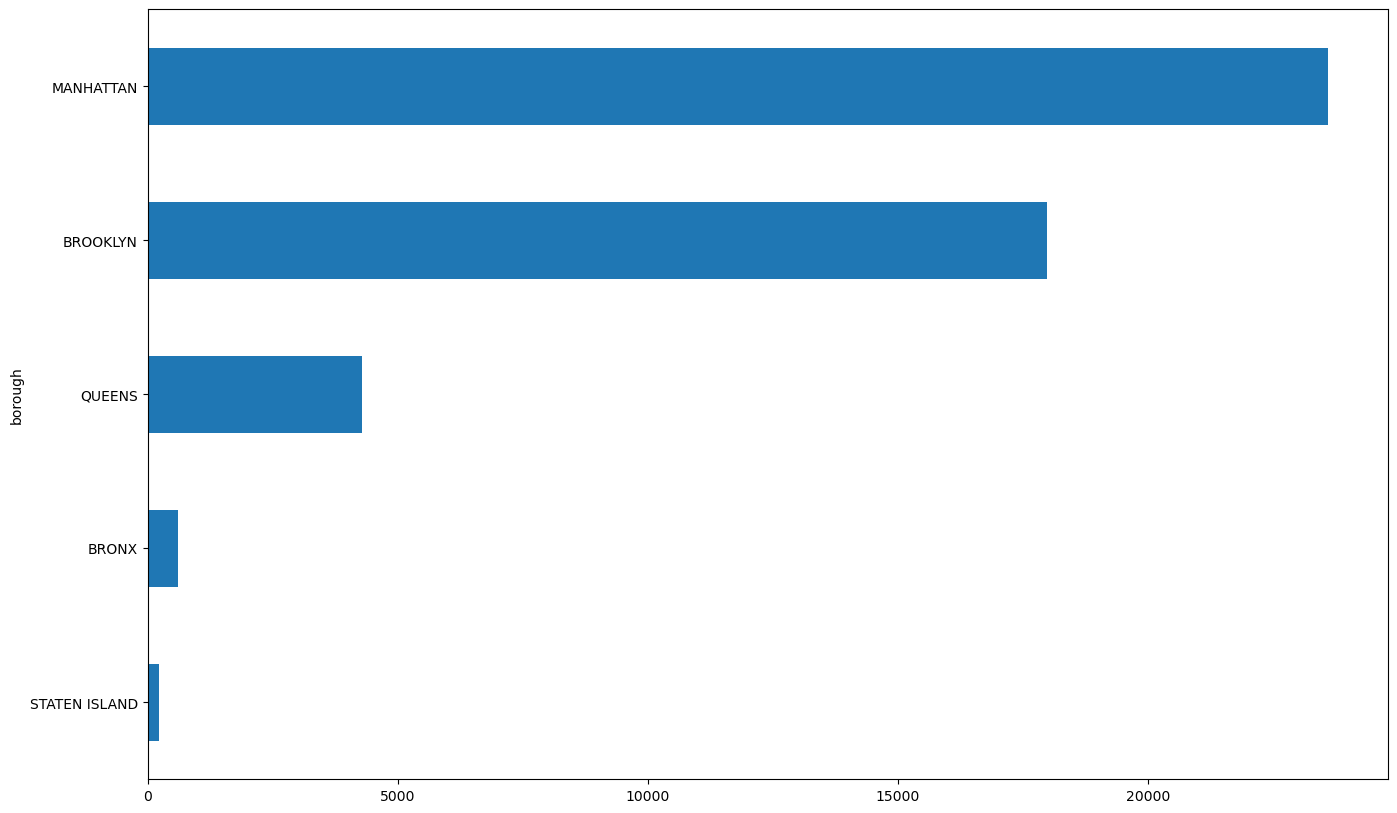

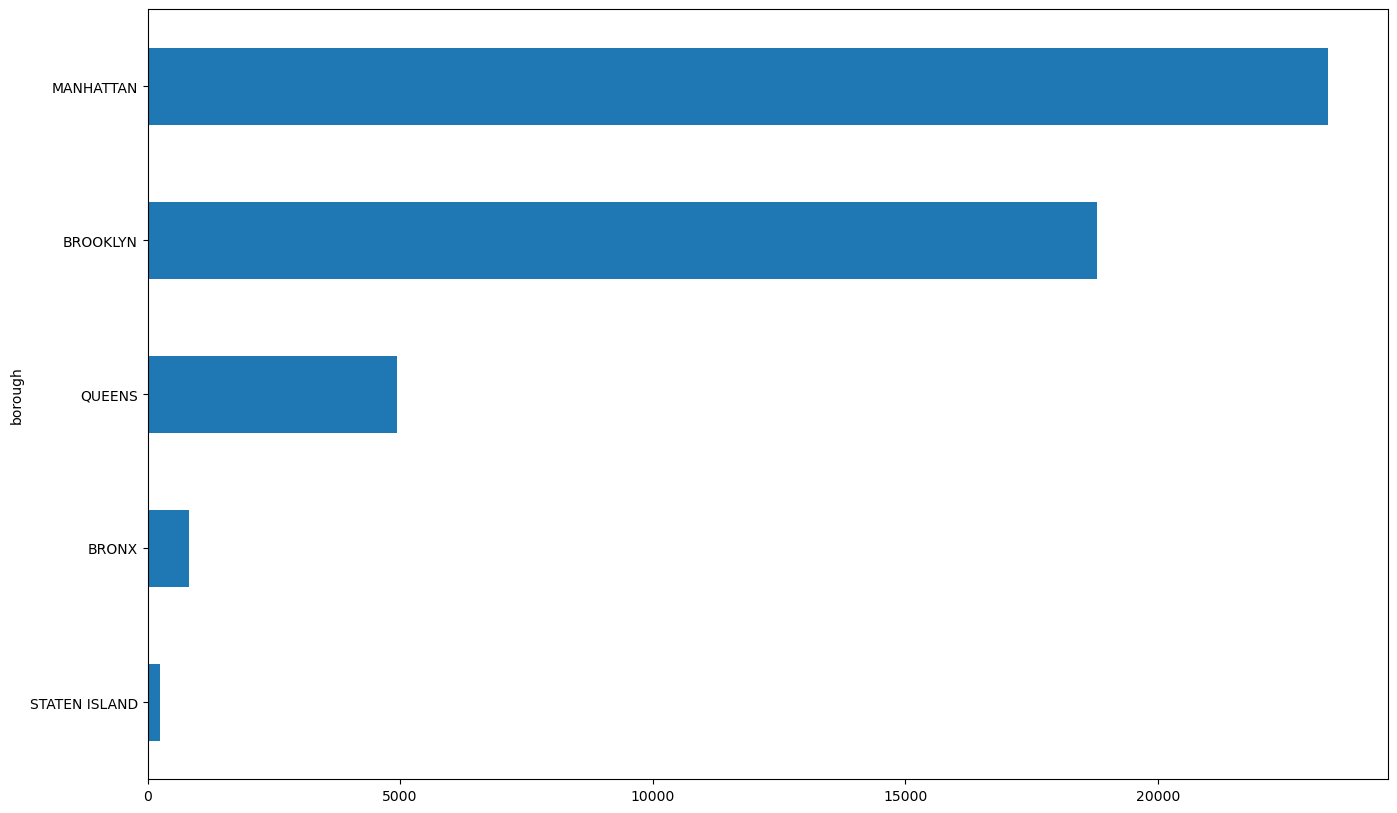

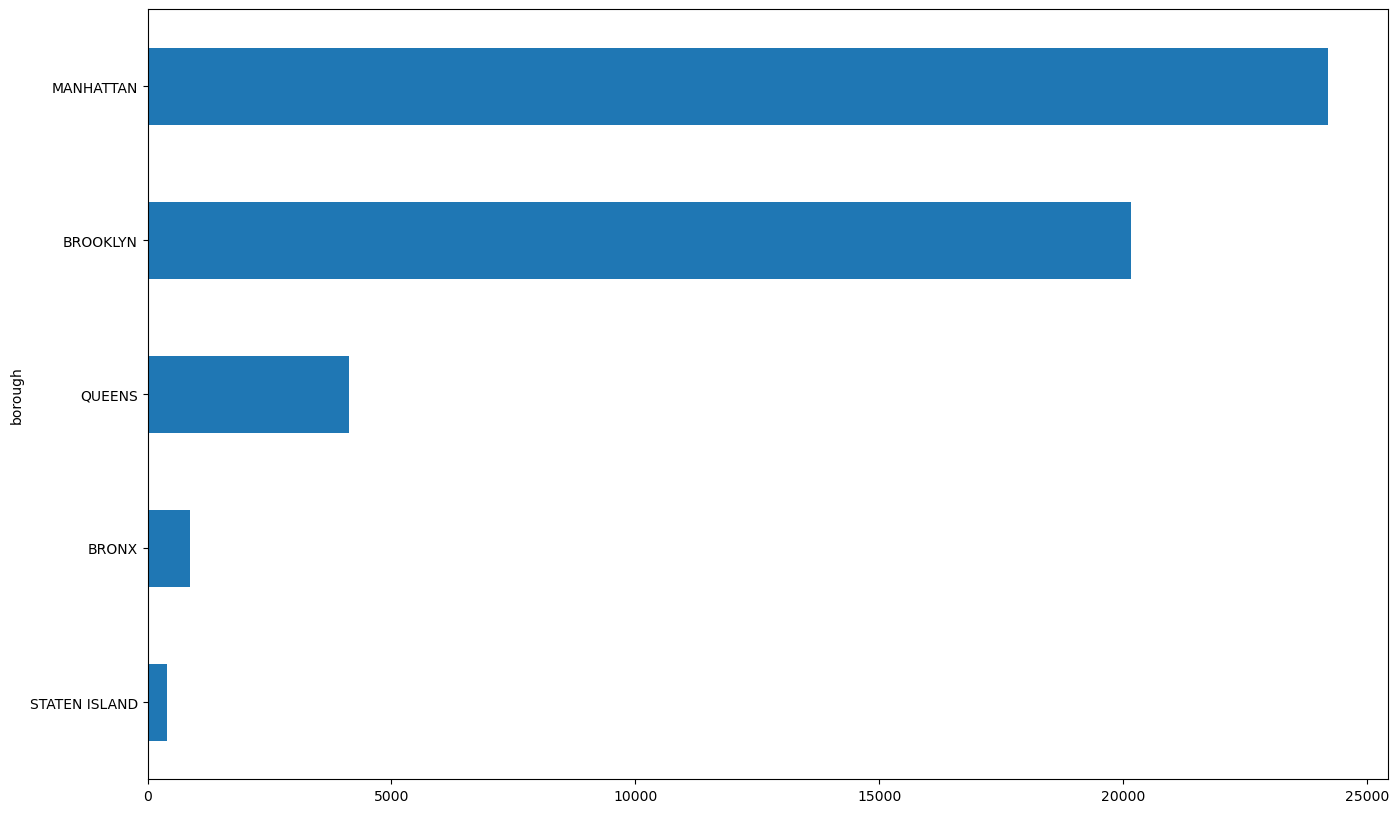

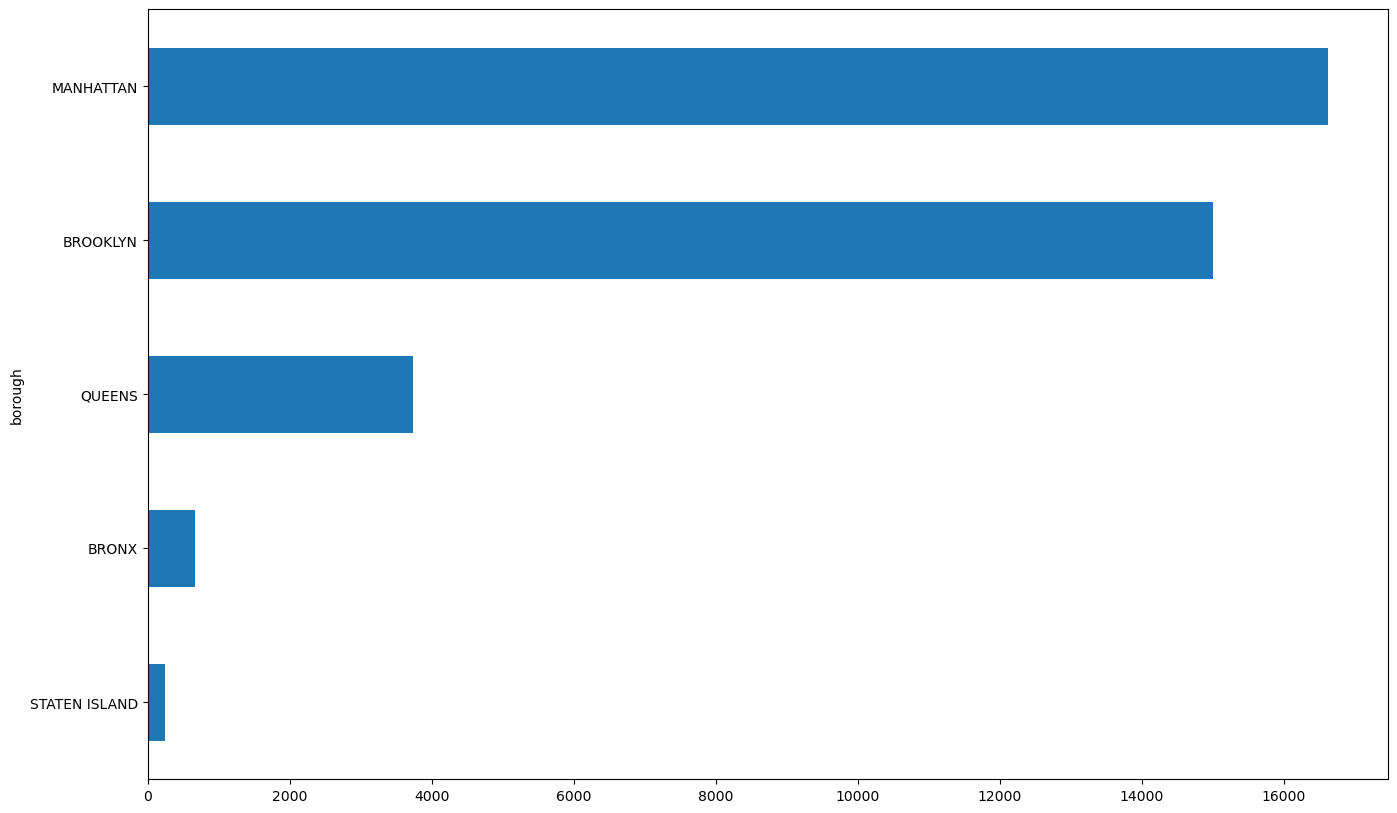

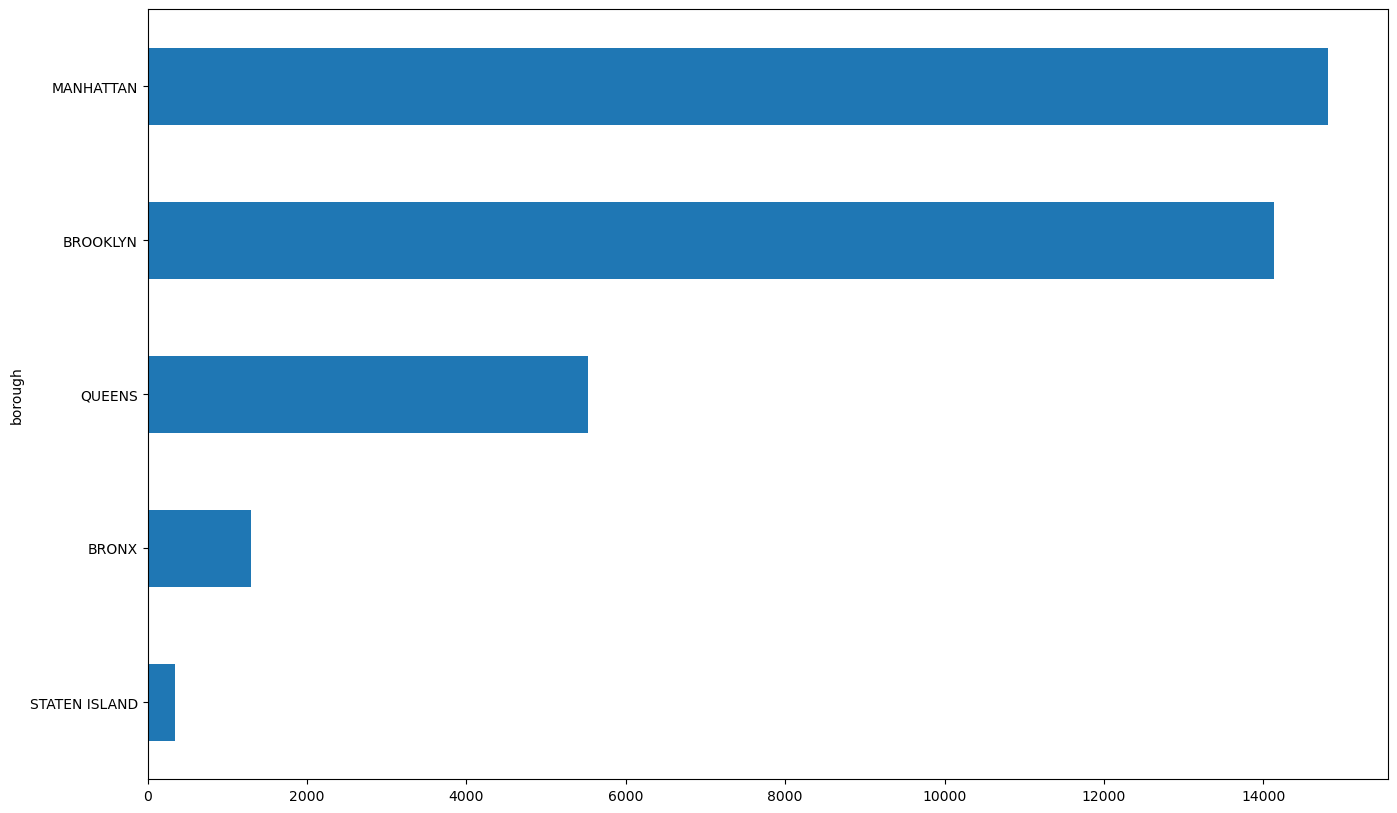

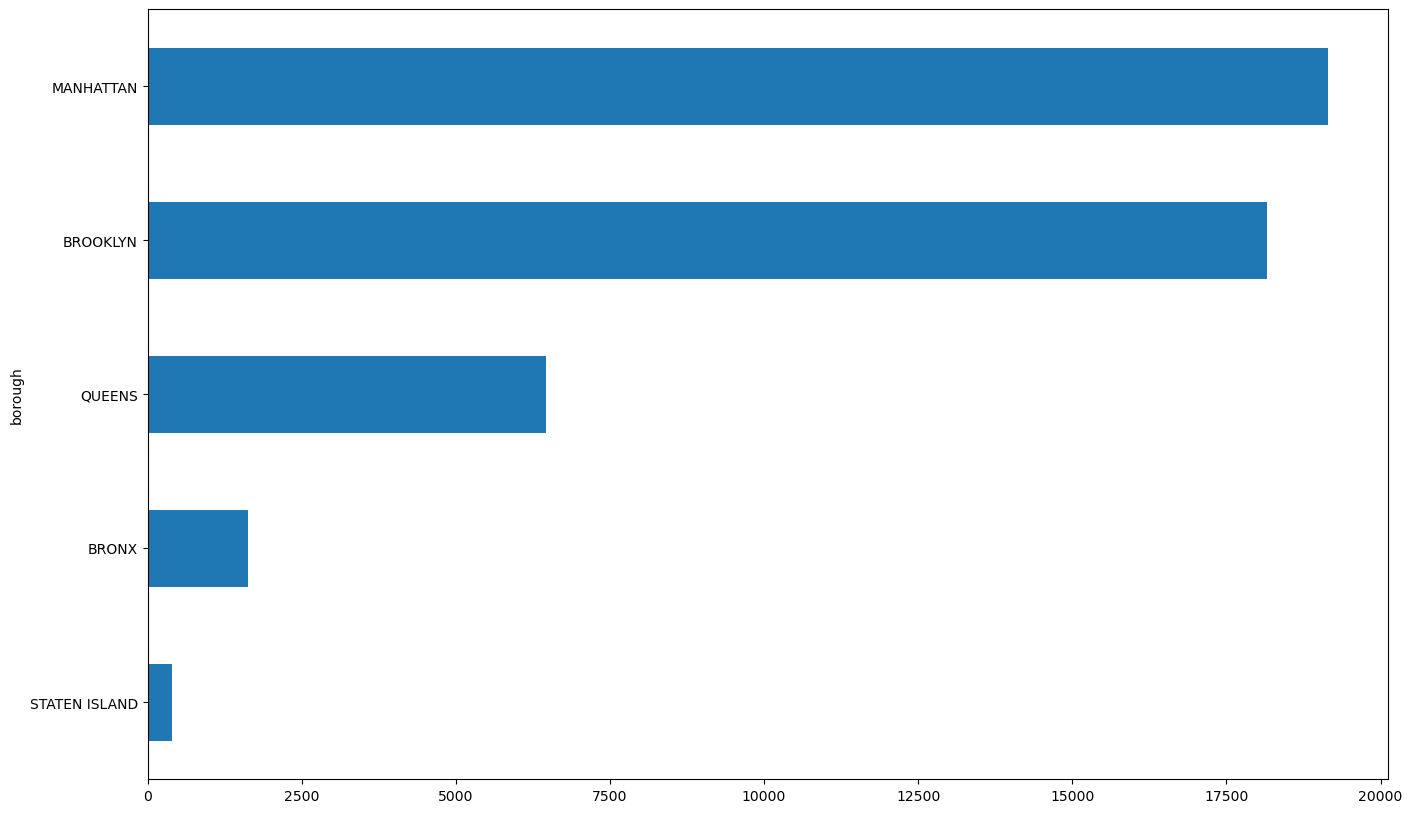

In [12]:
x = len(years)
for i in range(0,x):
    plt.figure(figsize =(16,10))
    abnb_df[abnb_df['year'] == years[i]].groupby(['borough'])['id'].count().sort_values().plot.barh()
    plt.show()

In [16]:
def get_groupby_count(df, groupby_cols, value):
    data = df.groupby(groupby_cols)[value].count().to_frame().reset_index()
    data = data.rename(columns={value:'count'})
    data["year"] = data["year"].apply(lambda x: x.year)
    return data

In [17]:
# Create comparison chart for all boros and NYC based on `value` column
def boro_comparison_line(df, value):
    boro_data = get_groupby_count(df, ['year', 'borough'], value)   
    nyc_data = get_groupby_count(df, ['year'], value)
    nyc_data["borough"] = "NYC"
    
    data = pd.concat([boro_data, nyc_data])

    chart = sns.lineplot(x="year", y="count", hue="borough", data=data)
    chart.axes.set_title("Airbnb count for each borough and NYC".format(value))

/Users/sergioferreira/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

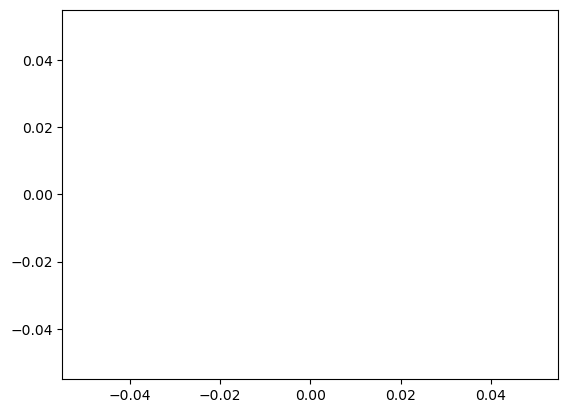

In [20]:
boro_comparison_line(abnb_df,'id')

In [19]:
# Generate zipcode count
def create_boro_count_chart(df, count_col):
    return get_groupby_count(df, [count_col, "borough", "year"], "id").reset_index(drop=True)

In [21]:
zip_boro_count = create_boro_count_chart(abnb_df, "zipcode")
zip_boro_count.head()

,zipcode,borough,year,count
0,10001,MANHATTAN,2015,350
1,10001,MANHATTAN,2016,666
2,10001,MANHATTAN,2017,418
3,10001,MANHATTAN,2018,491
4,10001,MANHATTAN,2019,275


In [22]:
# HELPER FUNCTION
def map_boro_color(boro):
    boro_color_mapper = {"BRONX": "red", "BROOKLYN": "brown", "MANHATTAN": "blue", "QUEENS": "purple", "STATEN ISLAND": "grey"}
    return boro_color_mapper[boro]

In [23]:
def map_boro_count(data, boro, year):
    data = data[data["borough"]== boro]
    data = data[data["year"] == year]
    
    color = map_boro_color(boro) 
    order = data.sort_values(by='count').zipcode
    
    rcParams['figure.figsize'] = 11.7,8.27
    chart = sns.barplot(data=data, y="count", x="zipcode", color=color, order=order)
    chart.axes.tick_params(axis='x', rotation=90)
    chart.set_title("{} zipcode count for year {}".format(boro, year))
    return data


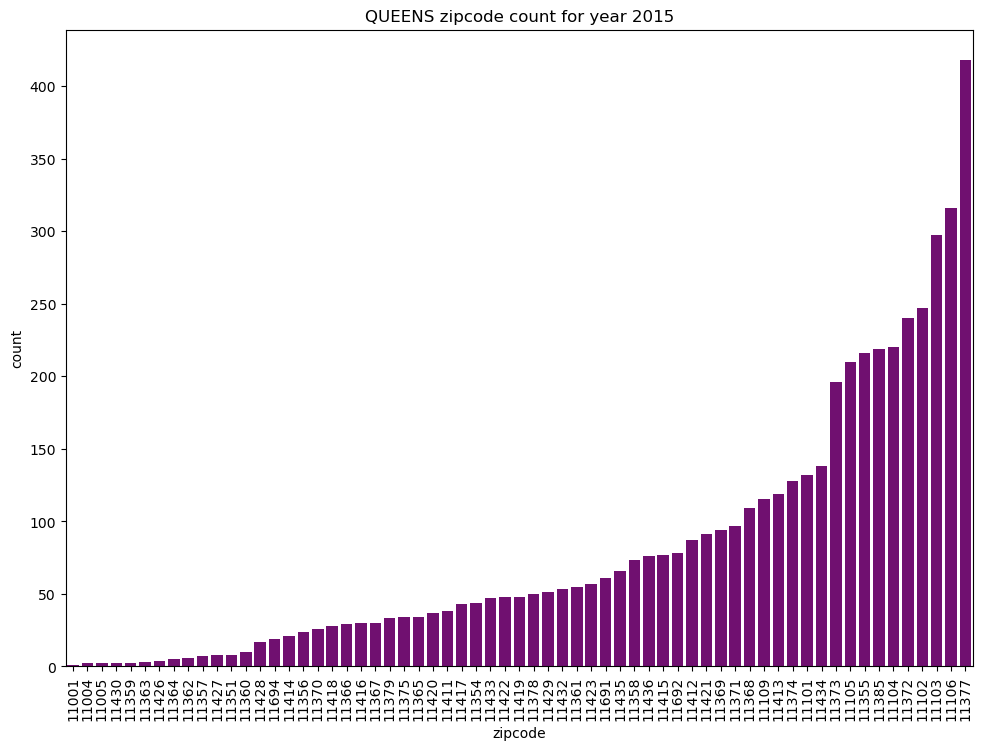

In [24]:
q = map_boro_count(zip_boro_count, "QUEENS", 2015)

In [25]:
abnb_df['year'] = abnb_df['year'].astype(str)
acs_df['year'] = acs_df['year'].astype(str)

In [26]:
acs_df.keys()

Index(['borough', 'total_housing_units', 'occupied_housing_units',
       'vacant_housing_units', '1_room_units', '2_room_units', '3_room_units',
       '4_room_units', '5_room_units', '6_room_units', '7_room_units',
       '8_room_units', '9_room_units', 'unit_median_rooms', 'unit_no_bedrooms',
       'unit_1_bedrooms', 'unit_2_bedrooms', 'unit_3_bedrooms',
       'unit_4_bedrooms', 'unit_5+_bedrooms', 'owner_occupied_units',
       'renter_occupied_units', 'occupants_per_room_<=1',
       'occupants_per_room_1-1.5', 'occupants_per_room_>=1.5',
       'owned_median_value', 'rent_median_value', 'year'],
      dtype='object')

In [ ]:
def grouping (df1, df2, group_val, stats):
    plt1 = df1[['year','borough','vacant_housing_units']].sort_values('borough').reset_index(drop=True)
    plt2 =abnb_df.groupby(['borough','year'])['id'].size().to_frame().reset_index()

In [27]:
#x=len(years)
#for i in range(0,x):
#    acs_df[acs_df['year']== year[i]]
plt1 = acs_df[['year','borough','vacant_housing_units']].sort_values('borough').reset_index(drop=True)
plt2 =abnb_df.groupby(['borough','year'])['id'].size().to_frame().reset_index()
pltf = pd.merge(plt1,plt2, on=['borough','year'])
pltf['year']=pltf['year'].astype(int)
pltf = pltf.sort_values(['borough','year'])
pltf = pltf.rename(columns={'id':'abnb_count'})

In [28]:
boro_list = list(pltf['borough'].unique())

<Figure size 700x300 with 0 Axes>

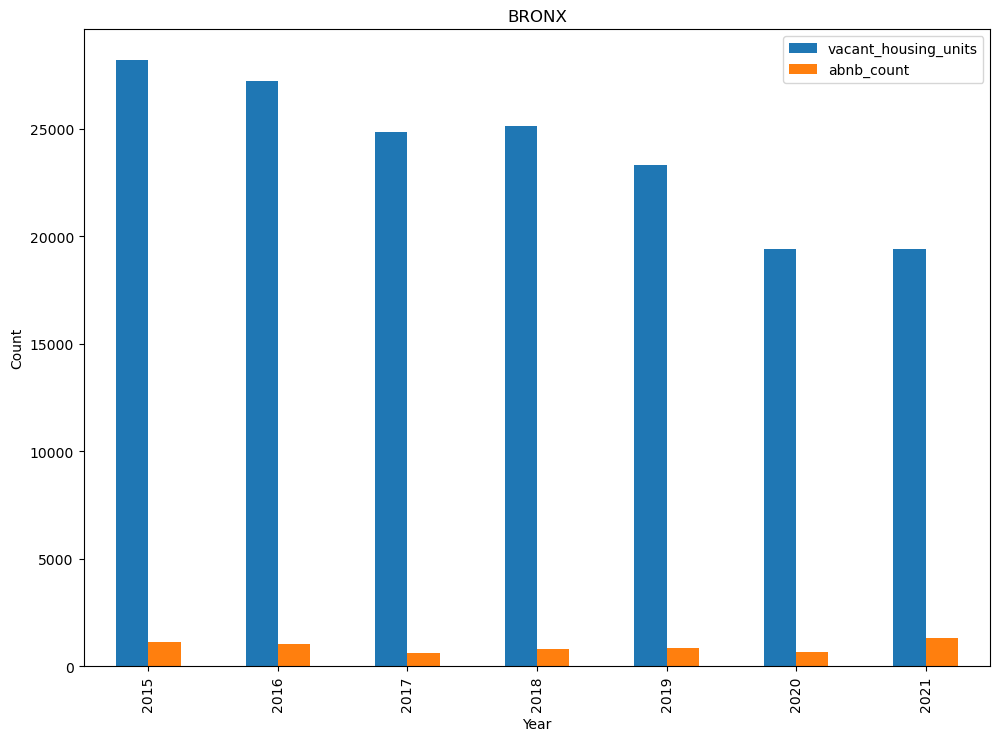

<Figure size 700x300 with 0 Axes>

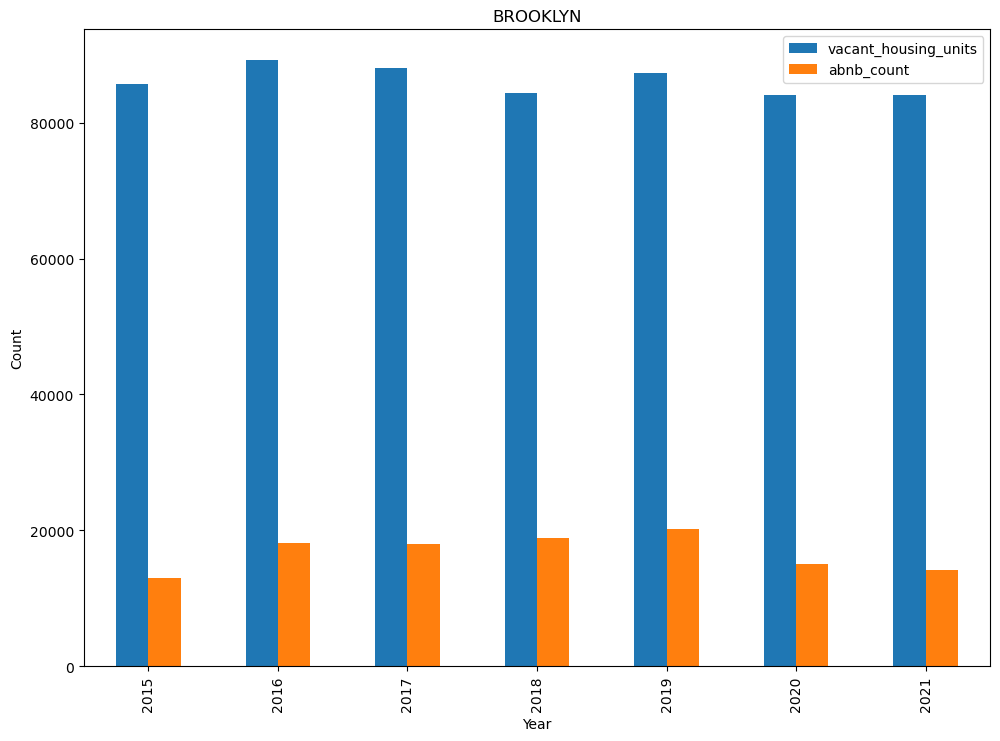

<Figure size 700x300 with 0 Axes>

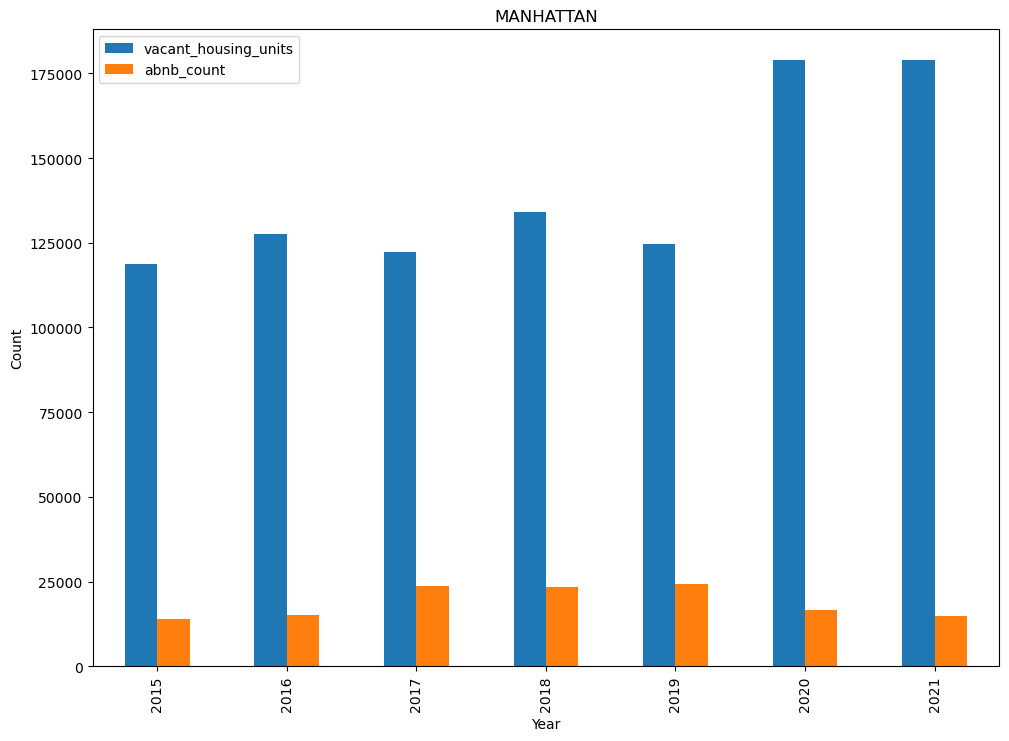

<Figure size 700x300 with 0 Axes>

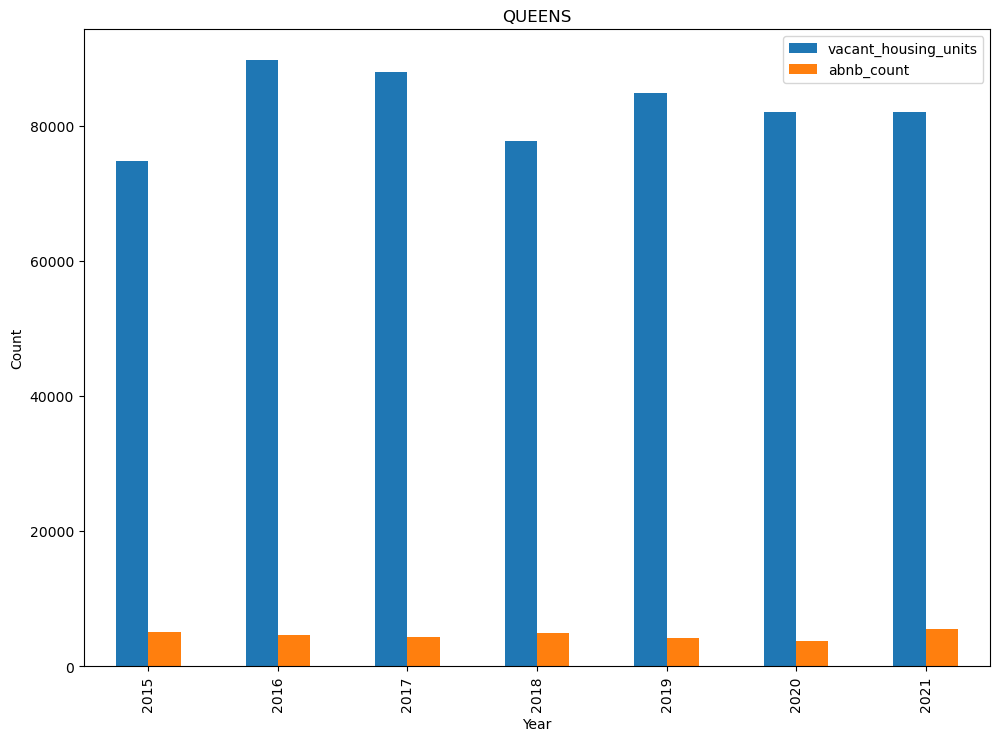

<Figure size 700x300 with 0 Axes>

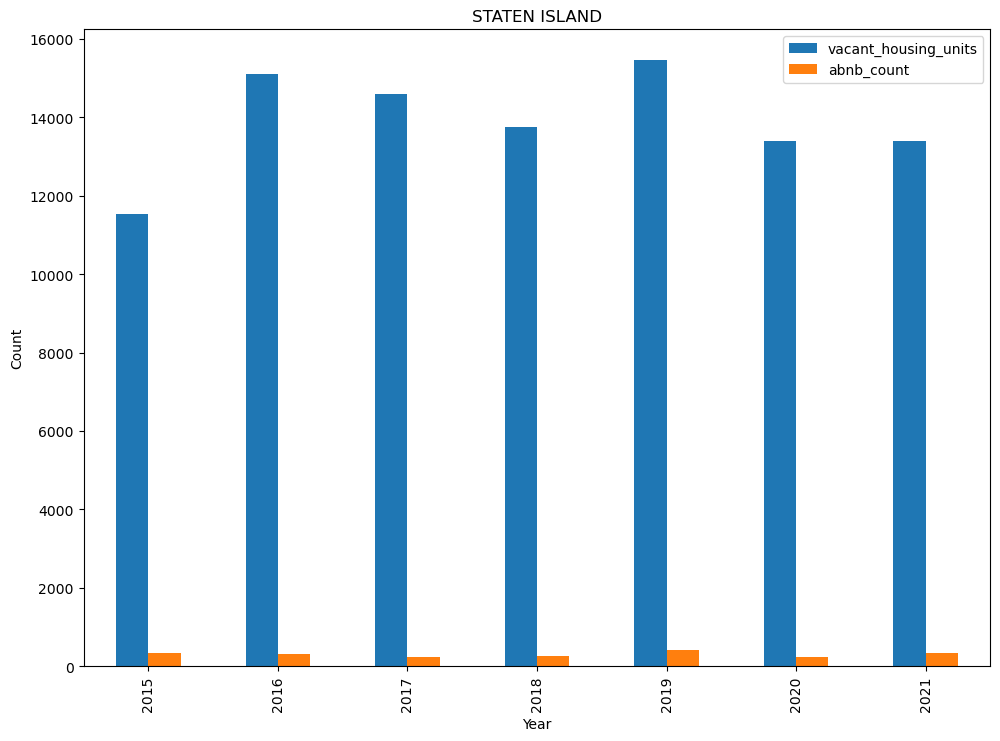

In [29]:
for boro in boro_list:
    plt.figure(figsize =(7,3))
    pltf[pltf['borough'] == boro].plot.bar(x='year')
    plt.xlabel('Year') 
    plt.ylabel('Count') 
    plt.title(boro)
    plt.show()
    
#pltf.plot.bar(x='borough')
#plt.xticks(rotation=0)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

In [30]:
plt1 = acs_df[['year','borough','rent_median_value']].sort_values('borough').reset_index(drop=True)
plt2 =abnb_df.groupby(['borough','year'])['id'].size().to_frame().reset_index()
pltf = pd.merge(plt1,plt2, on=['borough','year'])
pltf['year']=pltf['year'].astype(int)
pltf = pltf.sort_values(['borough','year'])
pltf = pltf.rename(columns={'id':'abnb_count'})

<Figure size 700x300 with 0 Axes>

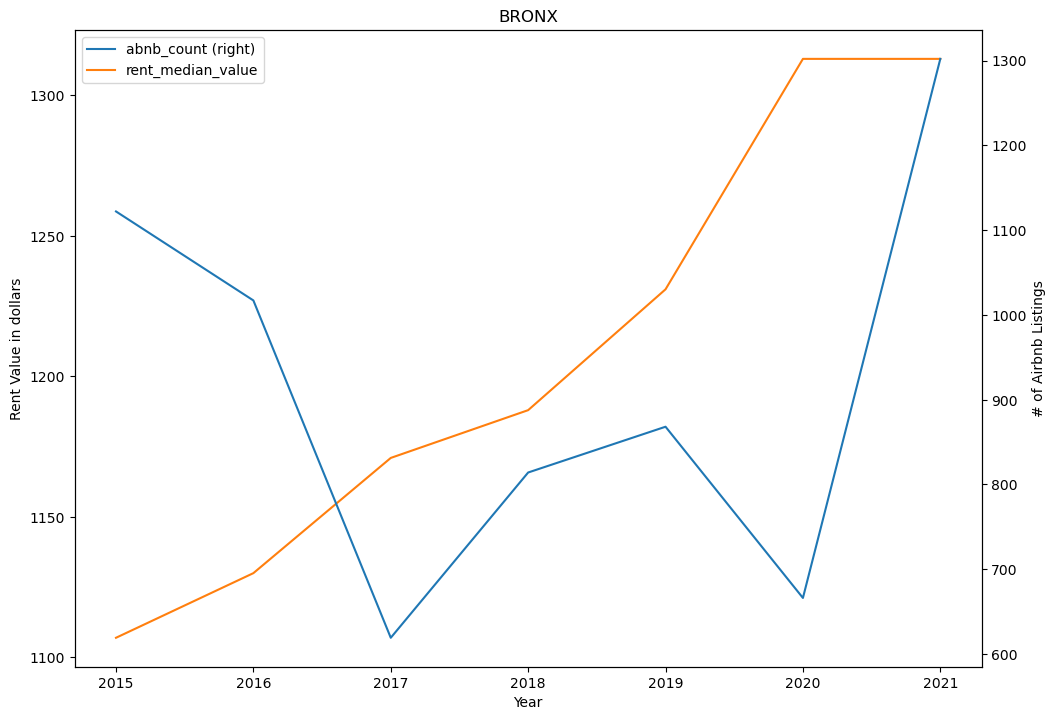

<Figure size 700x300 with 0 Axes>

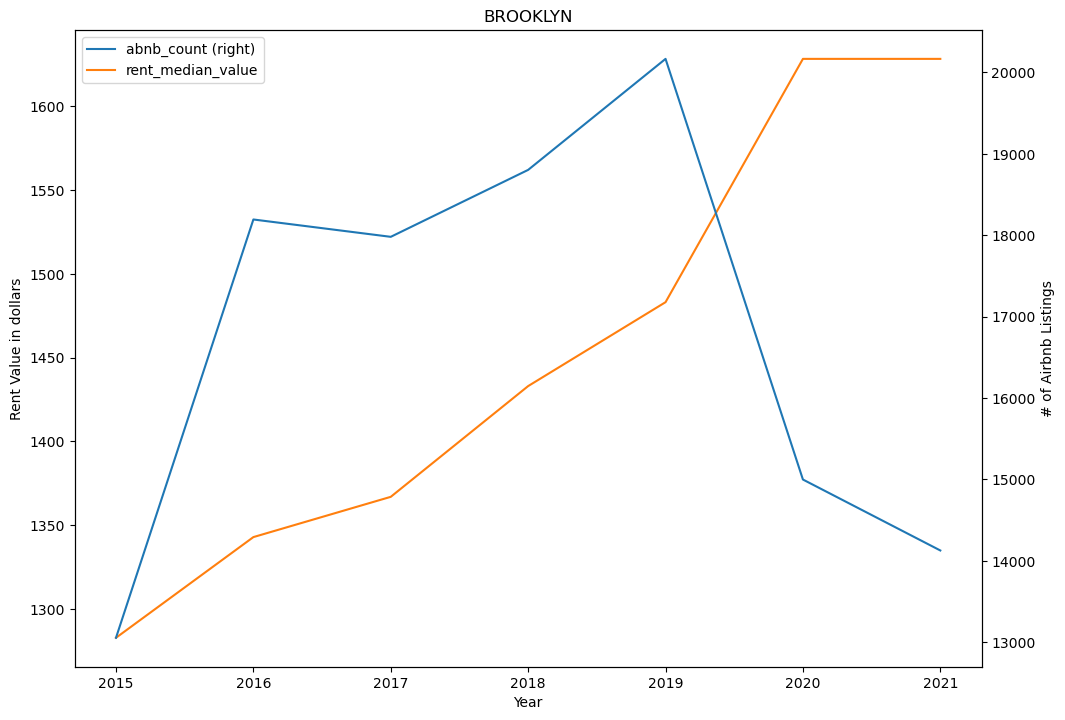

<Figure size 700x300 with 0 Axes>

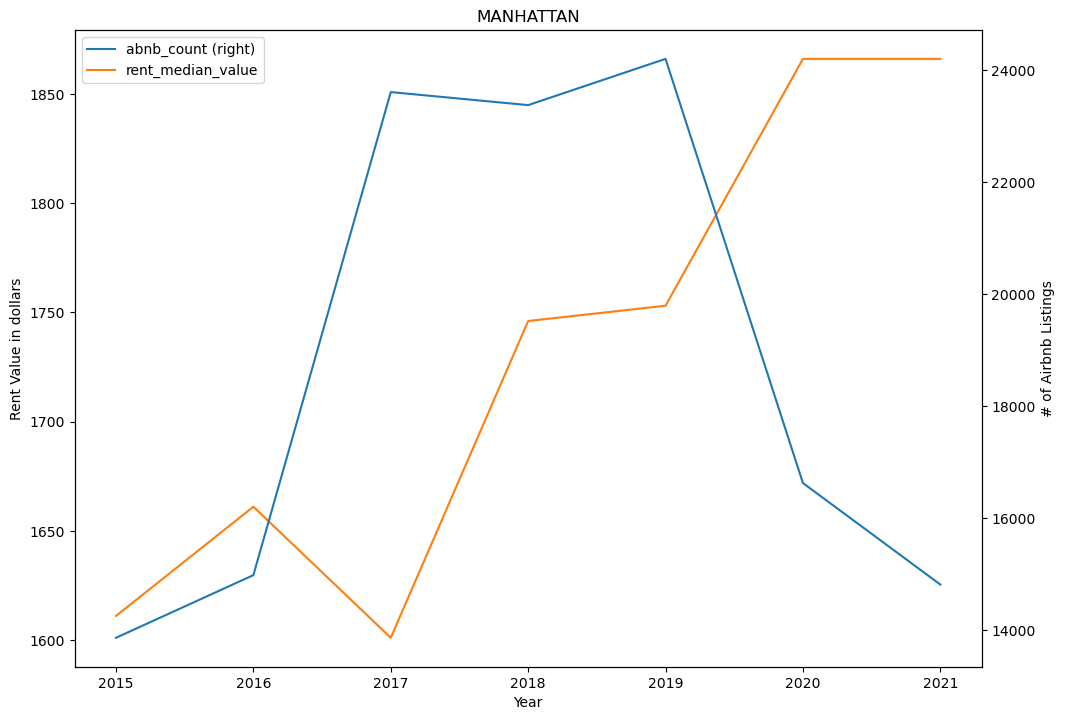

<Figure size 700x300 with 0 Axes>

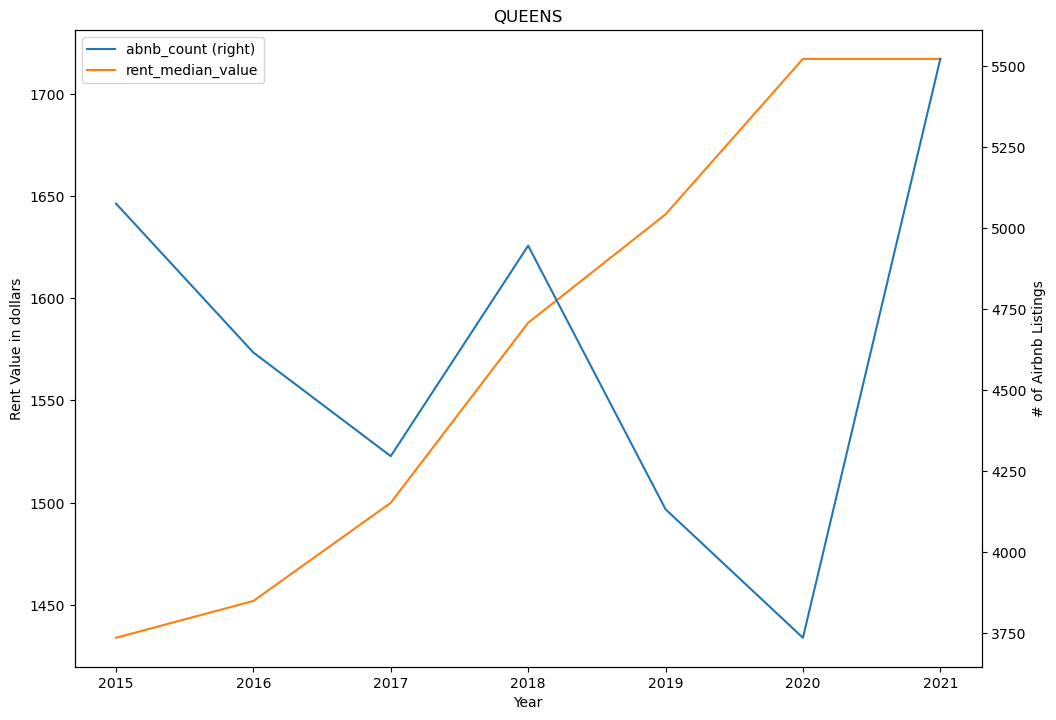

<Figure size 700x300 with 0 Axes>

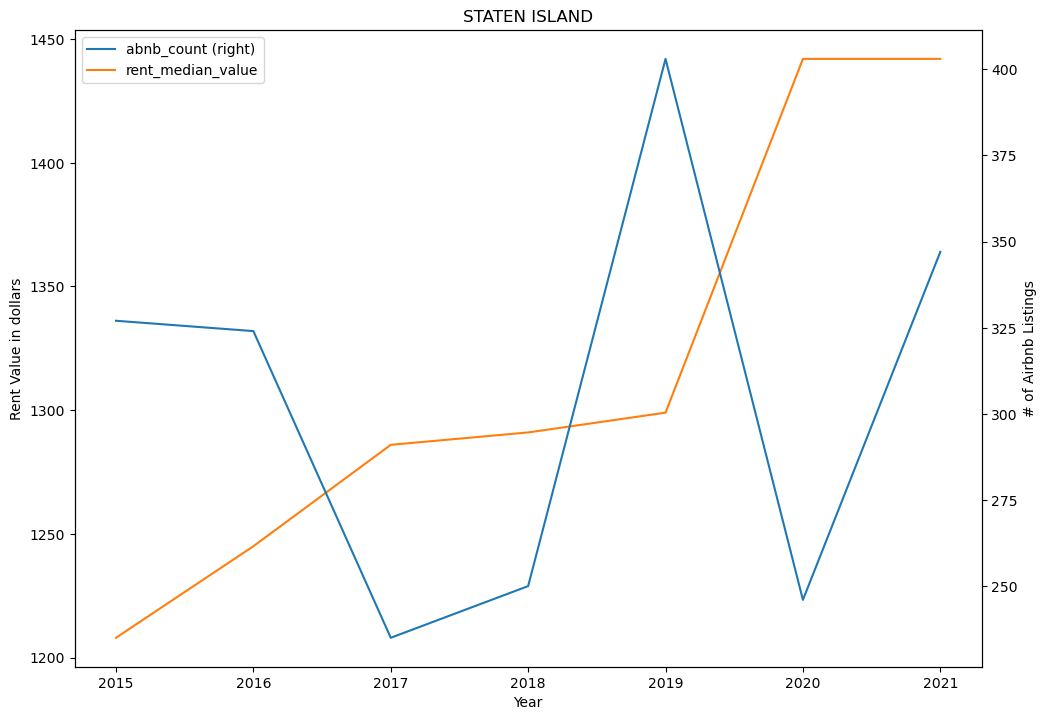

In [31]:
for boro in boro_list:
    plt.figure(figsize =(7,3))
    pltf[pltf['borough'] == boro].plot('year',['abnb_count','rent_median_value'], xlabel='Year'
                                       ,ylabel='Rent Value in dollars', secondary_y='abnb_count')
    plt.ylabel('# of Airbnb Listings') 
    plt.title(boro)
    plt.show()

In [32]:
zrent_df['date']

0       2015-03-31
1       2015-03-31
2       2015-03-31
3       2015-03-31
4       2015-03-31
           ...    
8731    2022-10-31
8732    2022-10-31
8733    2022-10-31
8734    2022-10-31
8735    2022-10-31
Name: date, Length: 8736, dtype: object

In [33]:
zrent_df['time'] = pd.to_datetime(zrent_df['date']).dt.to_period('Y').astype(str)
abnb_df['time'] = pd.to_datetime(abnb_df['last_scraped']).dt.to_period('Y').astype(str)
zrent_df = zrent_df.rename(columns={'zip_code':'zipcode'})

In [34]:
zrent_df.sort_values(['zipcode','time']).head(15)

,zipcode,state,city,borough,date,mean_rent,time
71,10001,NY,New York,MANHATTAN,2015-03-31,3898.696393,2015
153,10001,NY,New York,MANHATTAN,2015-04-30,3945.622620,2015
235,10001,NY,New York,MANHATTAN,2015-05-31,3985.822896,2015
318,10001,NY,New York,MANHATTAN,2015-06-30,4047.122133,2015
401,10001,NY,New York,MANHATTAN,2015-07-31,4043.509711,2015
484,10001,NY,New York,MANHATTAN,2015-08-31,4025.670248,2015
567,10001,NY,New York,MANHATTAN,2015-09-30,4014.194042,2015
650,10001,NY,New York,MANHATTAN,2015-10-31,4039.362019,2015
733,10001,NY,New York,MANHATTAN,2015-11-30,4050.174670,2015
816,10001,NY,New York,MANHATTAN,2015-12-31,4049.849765,2015


In [35]:
plt1 = zrent_df.groupby(['time','borough','zipcode'])['mean_rent'].mean().to_frame().reset_index().sort_values(['zipcode','time'])
plt1

,time,borough,zipcode,mean_rent
33,2015,MANHATTAN,10001,4010.002450
117,2016,MANHATTAN,10001,4022.985795
205,2017,MANHATTAN,10001,3958.378503
295,2018,MANHATTAN,10001,4001.064029
385,2019,MANHATTAN,10001,4145.262809
...,...,...,...,...
438,2019,QUEENS,11435,1708.722415
536,2020,QUEENS,11435,1747.118040
642,2021,QUEENS,11435,1778.252589
778,2022,QUEENS,11435,1904.273478


In [36]:
plt1 = zrent_df.groupby(['time','borough','zipcode'])['mean_rent'].mean().to_frame().reset_index()#.sort_values('borough')
plt2 =abnb_df.groupby(['borough','time','zipcode'])['id'].size().to_frame().reset_index()
pltf = pd.merge(plt1,plt2, on=['borough','time','zipcode'])
#pltf['year']=pltf['year'].astype(int)
pltf = pltf.sort_values(['borough','time'])
pltf = pltf.rename(columns={'id':'abnb_count'})

In [38]:
pltf

,time,borough,zipcode,mean_rent,abnb_count
0,2015,BRONX,10457,1301.130802,51
1,2015,BRONX,10458,1412.186633,41
2,2015,BRONX,10461,1320.455377,49
3,2015,BRONX,10462,1372.011858,42
4,2015,BRONX,10463,2072.777743,48
...,...,...,...,...,...
702,2022,QUEENS,11426,2375.000000,5
703,2022,QUEENS,11432,2423.568844,73
704,2022,QUEENS,11434,2423.283148,188
705,2022,QUEENS,11435,1904.273478,72


<Figure size 700x300 with 0 Axes>

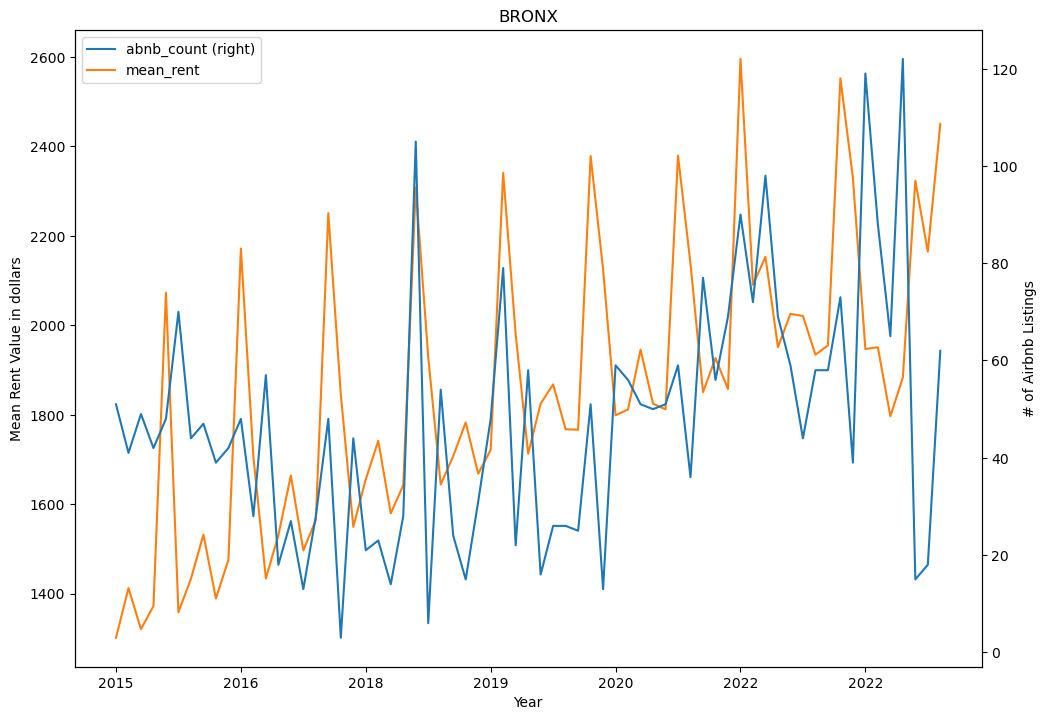

<Figure size 700x300 with 0 Axes>

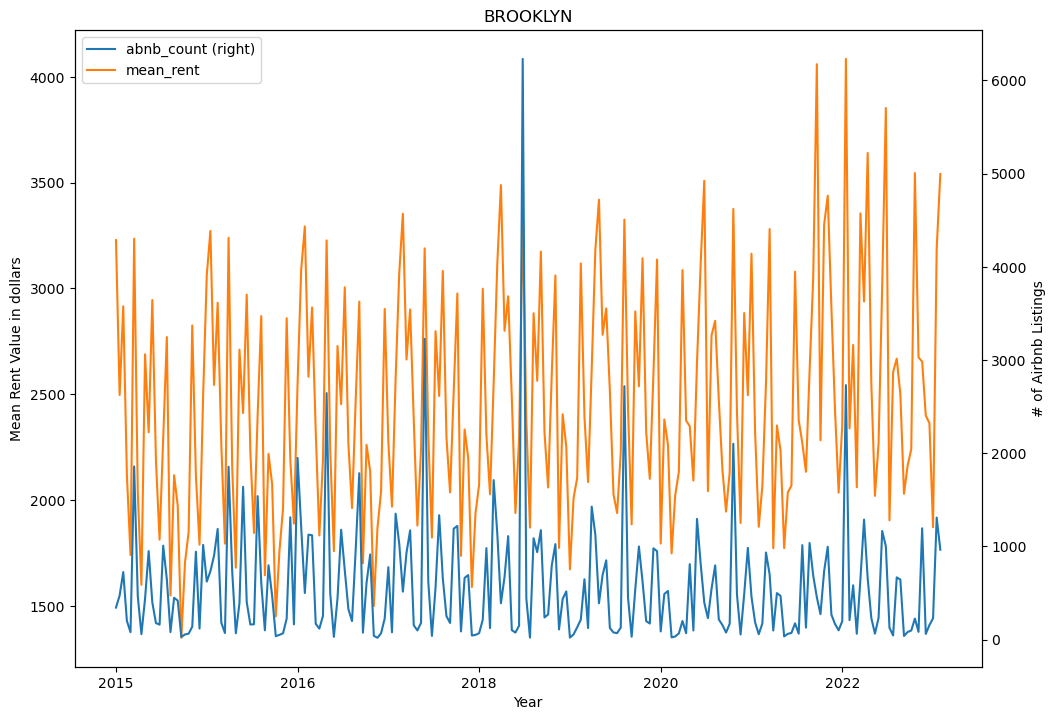

<Figure size 700x300 with 0 Axes>

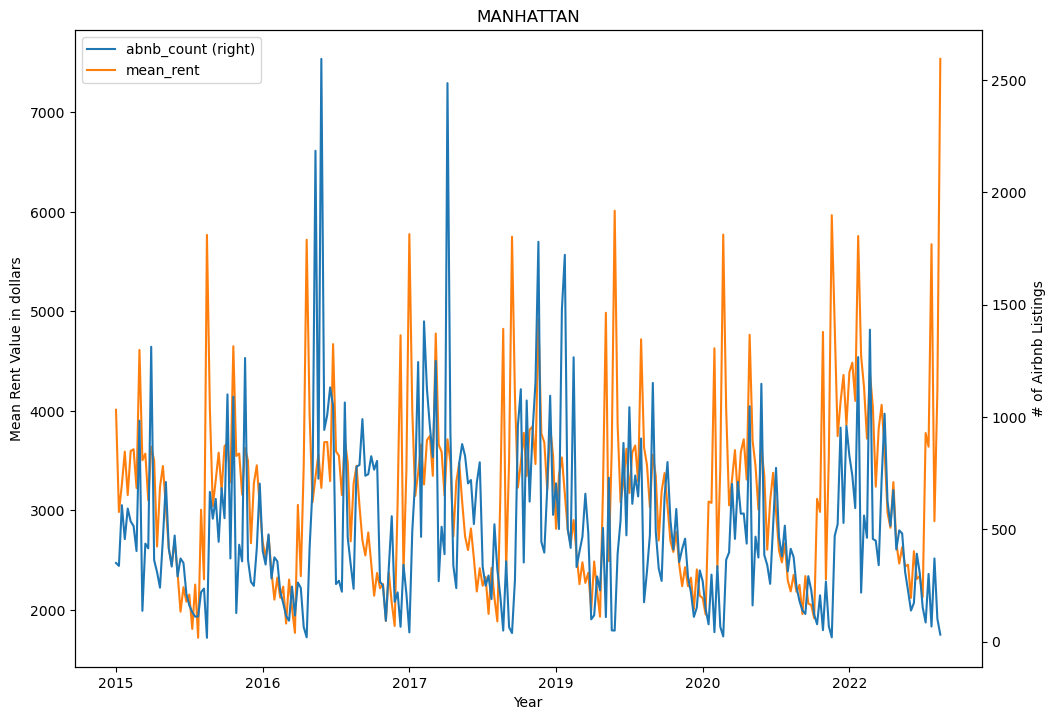

<Figure size 700x300 with 0 Axes>

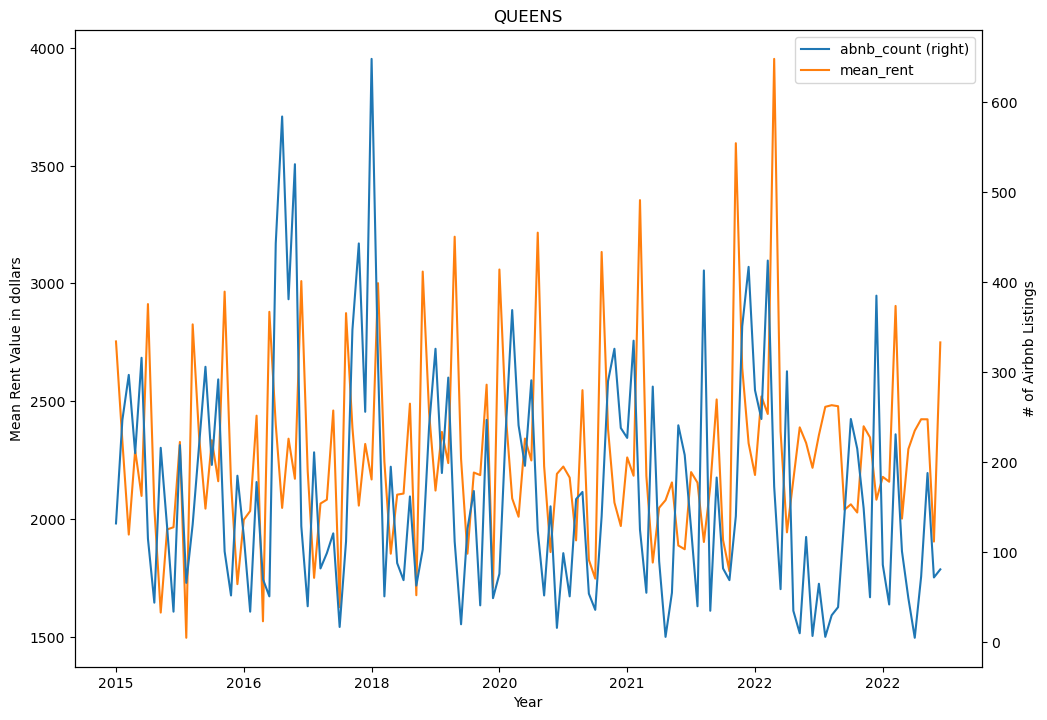

<Figure size 700x300 with 0 Axes>

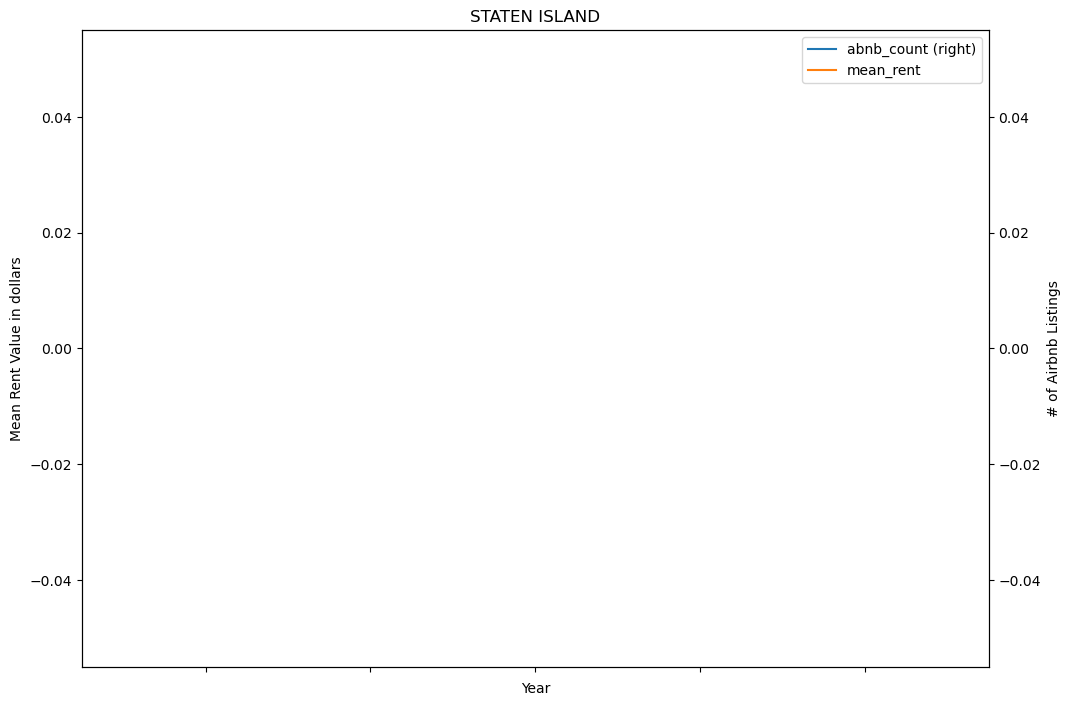

In [46]:
for boro in boro_list:
    plt.figure(figsize =(7,3))
    pltf[pltf['borough'] == boro].plot('time',['abnb_count','mean_rent'], xlabel='Year'
                                       ,ylabel='Mean Rent Value in dollars', secondary_y='abnb_count')
    plt.ylabel('# of Airbnb Listings') 
    plt.title(boro)
    plt.show()